In [2]:
##########################################
# To use tensorflow follow instructions here: https://www.tensorflow.org/install/pip
# follow instructions related to creating a virtual environment with conda which can be the same 
# environment as ska3 here: https://github.com/sot/skare3/wiki/Ska3-runtime-environment-for-users
# ska is also needed
#########################################
# if any of these imports fail something is wrong with the environment
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Ska.engarchive import fetch
import Chandra.Time
from kadi import events

import timeit

In [3]:
import numexpr as ne
from Quaternion import Quat
import demo_functions as dmf

def quatty(quarts):
    quat = Quat(quarts)
    return ([quat.roll, quat.yaw])

# This function takes the aoattqt data and the msid data as an MSIDset
# and returns the combined dataset
def get_all_data(msid_data, quat_data, pitch_data):
    t1998 = 883612730.816
    from mica.quaternion import normalize
    quat_vals = normalize(np.vstack([quat_data["{}{}".format('AOATTQT',i)].vals for i in [1,2,3,4]]).transpose())
    #quat_vals = pd.DataFrame(x)
    start_time = timeit.default_timer()
    quat_vect_new = dmf.get_quaternion(quat_vals)
    print ("got new quat vals: ", timeit.default_timer() - start_time)
    
    start_time = timeit.default_timer()
    #quat_vect = np.apply_along_axis(quatty, 1, quat_vals)
    #print ("quat vect shape: ", quat_vect.shape)
    print ("got quat vals: ", timeit.default_timer() - start_time)
    quat_times = data['AOATTQT1'].times
    print (quat_times.shape)
    #roll_v, yaw_v = quat_vect[:,0], quat_vect[:,1]
    new_roll, new_yaw = quat_vect_new[2] , quat_vect_new[3]
    #print ("equalities: ", np.all((roll_v ==roll_v==new_roll), np.all(yaw_v==new_yaw)))
    roll_df = pd.DataFrame({'times': quat_times, 'vals': new_roll})
    yaw_df = pd.DataFrame({'times':quat_times, 'vals': new_yaw})
    msid_data_tme = msid_data.times
    msid_times = np.array(pd.to_datetime(ne.evaluate('msid_data_tme + t1998'), 
                                         unit = 's', box = False), dtype = 'datetime64[s]')
    combined_dict = {'msid_times': msid_times, 
                     'raw_times': msid_data_tme,
                    'msid_vals': msid_data.vals,
                    'pitch': dmf.select_intervals(msid_data, pitch_data), 
                    'roll': dmf.select_intervals(msid_data,roll_df),
                    'yaw': dmf.select_intervals(msid_data, yaw_df)}
    return (combined_dict, quat_vect_new)

In [4]:
msid_value = 'OOBTHR39'
# ['OOBTHR41','AIRU1G2I','AIRU1G1I','AIRU2G1I','AIRU2G2I','OOBTHR08', 'OOBTHR39','OOBTHR41','OOBTHR06','OOBTHR08','OOBTHR09','OOBTHR18','OOBTHR19','OOBTHR25','OOBTHR26','OOBTHR40','OOBTHR51', '2CBLUAST','2CBHUAST', 'DP_PITCH']

###### STEP 2: SINGLE OR COMPARE MULTIPLE YEARS ######
train_years = [2014,2015,2016,2017,2018]
test_year = 2019

need_to_pull = []
import pickle , os
file_format = '{}_{}_msid_data.pkl'
test_msid_file = file_format.format(msid_value, test_year)

###### STEP 3: PULL + COLLATE DATA ######
# 'collate' means calculate and assign a pitch, roll, yaw value to each time period
# this is done using sad_common_functions can look there for more ingo
#########################################

#check if we already have the data for the test year
if os.path.isfile(test_msid_file):
    print('Test file already exists, will not pull')
else:
    need_to_pull += [test_year]

#check if we have data for all the training years
for t_year in train_years:
    train_file = file_format.format(msid_value, t_year)
    if not os.path.isfile(train_file):
        need_to_pull += [t_year]
print("Here are the years we will pull data for: ", need_to_pull)
print("WARNING: COLLATING ONE YEAR OF DATA TAKES AROUND 15 MINUTES")

#if we don't have data for training years we pull, collate and save it 
for pull_year in  need_to_pull:
    start = '{}:001:00:00:00'.format(pull_year)
    stop = '{}:366:24:60:60'.format(pull_year)
    print(start, stop)
    
    attitudes = ['AOATTQT1', 'AOATTQT2', 'AOATTQT3', 'AOATTQT4']
    data = fetch.MSIDset( [msid_value, 'DP_PITCH'] + attitudes, start, stop, filter_bad = True)
    
    combined_dict, quat_vect_new = get_all_data(data[msid_value], data, data['DP_PITCH'])
    save_file = file_format.format(msid_value, pull_year)
    f = open(save_file, "wb")
    pickle.dump(combined_dict, f)
    f.close()

Test file already exists, will not pull
Here are the years we will pull data for:  []


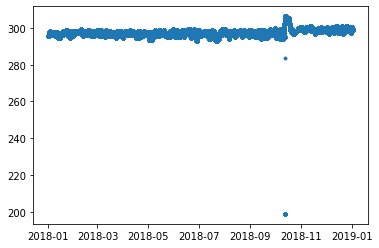

Enter a lower limit if needed:285
Enter an upper limit if needed:
(964153, 6)
           msid_times   msid_vals  pitch     raw_times    roll     yaw
0 2018-01-01 00:00:32  295.708313  48.87  6.311521e+08  137.05 -111.88
1 2018-01-01 00:01:05  295.708313  48.87  6.311521e+08  137.05 -111.87
2 2018-01-01 00:01:38  295.708313  48.87  6.311522e+08  137.05 -111.87
3 2018-01-01 00:02:11  295.708313  48.87  6.311522e+08  137.05 -111.87
4 2018-01-01 00:02:43  295.708313  48.87  6.311522e+08  137.05 -111.87


In [5]:
train_year = 2018
test_year = 2019
test_msid_file = file_format.format(msid_value, test_year)
train_msid_file = file_format.format(msid_value, train_year)

train_dict = pd.read_pickle(train_msid_file)
test_dict = pd.read_pickle(test_msid_file)

#here we plot our graph and take out any obvious outliers 
fig, axs = plt.subplots(1, 1)
train_set = pd.DataFrame(train_dict)
test_set = pd.DataFrame(test_dict)
#msid_set = pd.DataFrame({'times': data[msid_value].times, 'vals': data[msid_value].vals})
axs.plot(train_set.msid_times, train_set.msid_vals, '.')
plt.show()
lower_limit = input("Enter a lower limit if needed:")
upper_limit = input("Enter an upper limit if needed:")
if (lower_limit.isdigit()):
    lower_limit = int(lower_limit)
    train_set = train_set[(train_set['msid_vals']>lower_limit)]
if (upper_limit.isdigit()):
    upper_limit = int(upper_limit)
    train_set = train_set[(train_set['msid_vals']<upper_limit)]
print (train_set.shape)
print (train_set[:5])

In [6]:
#variables we will use 
cols = ['msid_times', 'msid_vals', 'pitch', 'roll','raw_times']
#the positions we are using can also include yaw if wanted to
pos = ['pitch', 'roll']
n_features = 3 #change this to 4 if we're using yaw
frames = 8
spacing_int = 30
percentage = 0.2

In [ ]:
# an LSTM model takes as a 3d tensor so we need to reshape our data to fit that
# the shape is a 3d tensor with dimensions (batch_size, time_steps, features)
np.random.seed(0)
from keras.callbacks import Callback
from keras import backend as K
from keras import models, callbacks


from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.regularizers import l2
from keras.engine import training_arrays

def create_model(n_neurons, timesteps, data_dim, p_W, p_U, weight_decay, p_dense):
    #dropout is used for uncertainty calculations
    model=Sequential()
    model.add(LSTM(n_neurons, input_shape = (timesteps, data_dim),
                   kernel_regularizer=l2(weight_decay), U_regularizer=l2(weight_decay),
                   bias_regularizer=l2(weight_decay), dropout=p_W, recurrent_dropout=p_U))
    model.add(Dropout(p_dense))
    model.add(Dense(1,  kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    optimiser = 'adam'
    model.compile(loss='mean_squared_error', optimizer=optimiser, metrics = ['accuracy'])
    return model

#first we clean our training set and rows with null values
train_clean_set, train_raw_time, train_time = dmf.clean_data(train_set, cols, pos)
raw_msid_val = train_clean_set.drop(pos, axis = 1)
#scale training data and return the scalers so we can use them to unscale
scaler_all, scaler_msid, scaled_train = dmf.scale_training(train_clean_set, raw_msid_val)
# shape data using our common function 
# this common function returns data in roll(t-8), pitch(t-8), val(t-8)... val(t) 
# drops pitch(t) and roll(t)
shaped_train, begin_int = dmf.shaping_data(scaled_train, pos, frames)
# take the shaped data and return an averaged version 
variables = pos + ['msid_vals']
averaged_obs, train_time_avg = dmf.get_averaged_data(scaled_train, train_time, spacing_int, variables)
shaped_train_avg, begin_int_avg = dmf.shaping_data(averaged_obs, pos, frames)
print ("This is the shape of your averaged training set: ", shaped_train_avg.shape, train_time_avg.shape)
#
# split training data that has already been shaped into training and validation
shaped_train_full, train_time_full, shaped_val_full, val_time_full = dmf.split_shaped_data(shaped_train, train_time, percentage, begin_int)
shaped_train_avg, train_time_avg, shaped_val_avg, val_time_avg = dmf.split_shaped_data(shaped_train_avg, train_time_avg, percentage, begin_int_avg)

#
# now clean, scale and shape the test data
#
test_clean_set, test_raw_time, test_time = dmf.clean_data(test_set, cols, pos)
# using the same scaler as the train set to scale the test set
scaled_test = scaler_all.transform(test_clean_set)
scaled_test = pd.DataFrame(scaled_test, columns = test_clean_set.columns)
shaped_test, begin_int_test = dmf.shaping_data(scaled_test, pos, frames)
test_time = test_time[begin_int_test:]
print ("This is the shape of your test set:", shaped_test.shape, test_time.shape)
print ("This is your test data reshaped:", shaped_test[:1])

big df shape:  (964153, 3)
    msid_vals(t-8)  pitch(t-8)  roll(t-8)  msid_vals(t-7)  pitch(t-7)  \
8         0.201863    0.016904   0.380694        0.201863    0.016904   
9         0.201863    0.016904   0.380694        0.201863    0.016904   
10        0.201863    0.016904   0.380694        0.201863    0.016904   
11        0.201863    0.016904   0.380694        0.201863    0.016904   
12        0.201863    0.016904   0.380694        0.201863    0.016904   

    roll(t-7)  msid_vals(t-6)  pitch(t-6)  roll(t-6)  msid_vals(t-5)  \
8    0.380694        0.201863    0.016904   0.380694        0.201863   
9    0.380694        0.201863    0.016904   0.380694        0.201863   
10   0.380694        0.201863    0.016904   0.380694        0.201863   
11   0.380694        0.201863    0.016904   0.380694        0.201863   
12   0.380694        0.201863    0.016904   0.380694        0.201863   

      ...     roll(t-3)  msid_vals(t-2)  pitch(t-2)  roll(t-2)  \
8     ...      0.380694        0.20

In [ ]:
# take shaped test, train and validation data and return inputs/outputs
# split io reshapes data to be 3D tensor shape (samples, timesteps, features)
# essentially whatev_X [[roll(t-8),pitch(t-8),val(t-8)]...[roll(t-1),pitch(t-1),val(t-1)]]
# whatev_y is [val(t)]
train_X_full, train_y_full = dmf.split_io(shaped_train_full, frames, n_features)
train_X_avg, train_y_avg = dmf.split_io(shaped_train_avg, frames, n_features)
validate_X, validate_y = dmf.split_io(shaped_val_full, frames, n_features)
test_X, test_y = dmf.split_io(shaped_test, frames, n_features)
train_X, train_y = train_X_avg, train_y_avg

#send p_dense to 0 to ignore dropout
p_W, p_U, p_dense, weight_decay, batch_size, n_neurons = 0.05, 0.05, 0.00, 1e-6, 512, 8
epochs = 100
#create model
timesteps, data_dim = train_X.shape[1] , train_X.shape[2]
checkpoint_path = 'weights_best_{}_yr{}_pW_{}_pU_{}_pdense{}'.format(msid_value,train_year, p_W, p_U, p_dense)
model = create_model(n_neurons, timesteps, data_dim, p_W, p_U, weight_decay, p_dense)

# checkpoint path to save weights
checkpointer = callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                         verbose = 0, save_best_only = True,
                                         save_weights_only = True, mode = 'min')
fit_time_begin = timeit.default_timer()
history = model.fit(train_X, train_y,validation_data=(validate_X, validate_y),
                    batch_size=batch_size, epochs=epochs, callbacks=[ checkpointer], shuffle = False , verbose = 0)
fit_time = timeit.default_timer() - fit_time_begin


interval 1 (771316, 24)
interval 2 (771316, 8, 3)
interval 1 (25704, 24)
interval 2 (25704, 8, 3)
interval 1 (192829, 24)
interval 2 (192829, 8, 3)
interval 1 (578212, 24)
interval 2 (578212, 8, 3)


/scratch1/miniconda3/envs/ska3/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(8, input_shape=(8, 3), kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., dropout=0.05, recurrent_dropout=0.05, recurrent_regularizer=<keras.reg...)`


In [ ]:
import math 
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

def plot_dashboard(plot_time, y_preds, y_actual, uncertainty, test_year, train_year, msid_value, optional_preds=None):
    #err_top, err_bot = y_preds-uncertainty , y_preds+uncertainty

    fig = plt.figure(figsize=(22.5, 15), constrained_layout=True)
    gs = fig.add_gridspec(6,3)

    ax1 = fig.add_subplot(gs[0:4,:-1])
    ##########################
    # Plotting Predicted vs Actual
    # x axis is time, y axis is msid
    ##########################
    ax1.plot(plot_time, y_preds, '.' , markersize = 1, label = 'predicted', color = 'tab:orange')
    if (optional_preds is not None):
        ax1.plot(plot_time, optional_preds, '.', markersize = 1, label = 'chain prediction', color = 'blue')
    ax1.plot(plot_time, y_actual, '.', markersize = 1, label = 'actual', color = 'black')
    #ax1.fill_between(plot_time.values, err_top, err_bot, label = 'uncertainty', color = 'grey')
    ax1.legend(markerscale=12.0)
    ax1.set_xticklabels(plot_time, rotation=45)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y:%j"))
    ax1.set_title('Predicted vs Actual {} {}'.format(msid_value, train_year))


    #########################
    # Plotting Model Error which is just actual y value minus test y value
    # x axis is time, y axis is error 
    #########################
    ax2 = fig.add_subplot(gs[4,:-1])
    errors =  y_actual - y_preds
    #dist_top = err_top - y_actual
    #dist_bot = err_bot - y_actual
    #one_perc = np.quantile(errors, 0.01)
    #nn_perc = np.quantile(errors, .99)
    scale = np.ptp(y_actual)/2.0
    ax2.plot(plot_time, errors, color = 'green')
    #ax2.plot(plot_time, dist_top, color = 'gray')
    #ax2.plot(plot_time, dist_bot, color = 'gray')
    ax2.set_ylim(-scale, scale)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticklabels(plot_time, rotation=45)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y:%j"))

    ax2.set_title('Model Error (Actual - Test) {} {}'.format(msid_value, train_year))

    #########################
    # Plotting Error by Temperature
    # 
    #########################
    ax3 = fig.add_subplot(gs[0:4,2])
    ax3.plot(errors, y_actual, '.', color = 'green')
    ax3.set_xlim(-scale, scale)
    ax3.set_ylim(ax1.get_ylim())
    ax3.set_title('Actual vs. Model Error {} {}'.format(msid_value, train_year))

    ax4 = fig.add_subplot(gs[4, 2])
    ax4.hist(errors, bins = 25, density=True, color= 'green')
    ax4.set_xlim(ax3.get_xlim())
    ax4.set_title("Error Distribution {} {}".format(msid_value, train_year))

    #plt.savefig('{}_test{}_train{}_full_dash.png'.format(msid_value, test_year, train_year))
    plt.show()

In [ ]:
predictions = model.predict(test_X)
scaled_predictions = scaler_msid.inverse_transform(predictions)

In [ ]:
uncertainty = []
y_actual = scaler_msid.inverse_transform(np.atleast_2d(test_y))
plot_dashboard(test_time, np.squeeze(scaled_predictions), np.squeeze(y_actual), uncertainty, test_year, train_year, msid_value)
